In [13]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [14]:
!pip install np_utils

In [12]:
from keras import utils

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'ellipsis'

In [15]:
import np_utils

In [7]:
!pip install opencv-python==4.5.5.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.9/29.9 MB 1.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [9]:
!pip install scikit-plot

In [16]:
INPUT_PATH = "/Users/arushtripathi/Downloads/CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

happy has 207 number of images
fear has 75 number of images
surprise has 249 number of images
sadness has 84 number of images
anger has 135 number of images


In [3]:
!pip install opencv-python

`sadness` and `fear` has very low number of images as compared to other classes

In [17]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

### Data Preprocessing

I first make the data compatible for neural nets

In [18]:
INPUT_PATH = "/Users/Snigdha1/Downloads/Fer2013/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [19]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [20]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [21]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

happy has 69 samples
fear has 25 samples
surprise has 83 samples
sadness has 28 samples
anger has 45 samples


In [23]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))
y = utils.to_categorical(y)

X.shape, y.shape

((250, 3, 48, 48, 1), (250, 5))

In [24]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.7, stratify=y, shuffle=True, random_state=42)
X_train.shape, X_valid.shape

((175, 3, 48, 48, 1), (75, 3, 48, 48, 1))

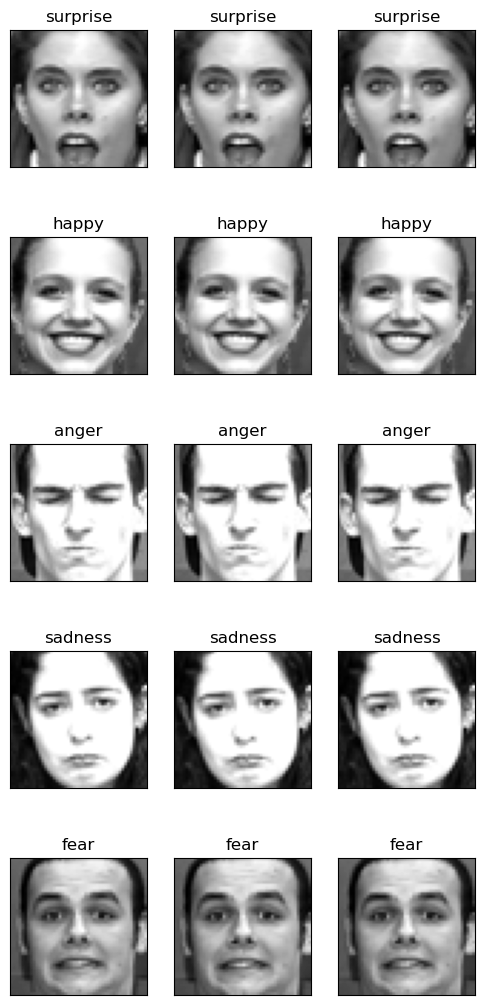

In [26]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [27]:
# data normalization
X_train = X_train / 255.
X_valid = X_valid / 255.

In [28]:
def build_dcnn(input_shape, show_arch=True):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.45, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.45, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.4, name='dropout_3'))

    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_7'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(
        Conv2D(
            filters=512,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_8'
        )
    )
    net.add(BatchNormalization(name='batchnorm_8'))
    
    net.add(Dropout(0.4, name='dropout_4'))
    
    net.add(GlobalMaxPool2D(name="globalmax2d"))
    
    if show_arch:
        net.summary()
    
    return net

In [29]:
def memory_model(input_shape, num_class, show_arch=True):
    dcnn = build_dcnn(input_shape[1:], show_arch=False)
    
    model = Sequential(name="ViT_Bidrectional_LSTM")

    model.add(
        TimeDistributed(
            dcnn,
            input_shape=input_shape,
            name="time_distributed",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

In [30]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.8,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 32
epochs = 100

In [31]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Nadam(0.001)

model = memory_model(INPUT_SHAPE, num_class=5)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

Model: "convolutional_Bidrectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 3, 512)            4691904   
 ributed)                                                        
                                                                 
 bidirectional (Bidirection  (None, 3, 256)            656384    
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 256)            0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                   

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, Dense, Dropout

def build_vit(input_shape, patch_size=8, num_patches=64, num_heads=8, ff_dim=64, num_classes=5):
    height, width, channels = input_shape

    # Calculate the number of patches
    patch_height = height // patch_size
    patch_width = width // patch_size

    # Create patch embedding layer
    patch_input = tf.keras.layers.Input(shape=input_shape)
    patches = tf.keras.layers.PatchExtractor(patch_size=(patch_size, patch_size))(patch_input)
    flattened_patches = tf.keras.layers.Reshape((patch_height * patch_width, patch_size * patch_size * channels))(patches)

    # Positional embeddings
    positions = tf.keras.layers.Embedding(input_dim=patch_height * patch_width, output_dim=ff_dim)(tf.range(patch_height * patch_width))

    # Add positional embeddings to patches
    embedded_patches = flattened_patches + positions

    # Multi-head self-attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)([embedded_patches, embedded_patches, embedded_patches])

    # Residual connection and layer normalization
    attention_output = tf.keras.layers.Add()([attention_output, embedded_patches])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feedforward neural network
    ffn = Dense(units=ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(units=ff_dim)(ffn)

    # Residual connection and layer normalization
    transformer_output = tf.keras.layers.Add()([ffn_output, attention_output])
    transformer_output = LayerNormalization(epsilon=1e-6)(transformer_output)

    # Global average pooling
    global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(transformer_output)

    # Dropout and final classification
    dropout = Dropout(0.5)(global_avg_pooling)
    output = Dense(num_classes, activation="softmax")(dropout)

    model = tf.keras.models.Model(inputs=patch_input, outputs=output)

    return model

# Example usage
input_shape = (48, 48, 3)
vit_model = build_vit(input_shape)
vit_model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, TimeDistributed, Bidirectional, LSTM
from your_vit_module import build_vit  

def vit_bilstm_model(input_shape, num_class, show_arch=True):
    vit_model = build_vit(input_shape)  

    model = tf.keras.Sequential(name="ViT_Bidirectional_LSTM")

    model.add(
        TimeDistributed(
            vit_model,
            input_shape=input_shape,
            name="time_distributed_vit",
        )
    )
    
    model.add(Bidirectional(LSTM(128, return_sequences=True, name="bidirect_lstm_1")))
    model.add(Dropout(0.35, name="dropout_1"))
    model.add(Bidirectional(LSTM(64, return_sequences=False, name="bidirect_lstm_2")))
    model.add(Dropout(0.45, name="dropout_2"))

    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    model.add(tf.keras.layers.BatchNormalization(name='batchnorm_1'))
    model.add(Dropout(0.7, name="dropout_3"))

    model.add(
        Dense(
            num_class,
            activation='softmax',
            name='out_layer'
        )
    )
    
    if show_arch:
        model.summary()
    
    return model

# Define input shape and number of classes
INPUT_SHAPE = (None, 48, 48, 3)  # Adjust dimensions as needed
NUM_CLASSES = 5

# Create and compile the model
model = vit_bilstm_model(INPUT_SHAPE, num_class=NUM_CLASSES)
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    metrics=['accuracy']
)


In [32]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_valid, y_valid),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Epoch 1/100
6/6 [==============================] - 13s 2s/step - loss: 3.1974 - accuracy: 0.2286 - val_loss: 1.7343 - val_accuracy: 0.1067 - lr: 0.0010
Epoch 2/100
6/6 [==============================] - 9s 2s/step - loss: 2.9646 - accuracy: 0.1943 - val_loss: 1.6527 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 3/100
6/6 [==============================] - 10s 2s/step - loss: 3.1462 - accuracy: 0.2057 - val_loss: 1.7376 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 4/100
6/6 [==============================] - 10s 2s/step - loss: 2.7331 - accuracy: 0.2457 - val_loss: 1.7191 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 5/100
6/6 [==============================] - 11s 2s/step - loss: 3.0880 - accuracy: 0.1829 - val_loss: 1.7226 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 6/100
6/6 [==============================] - 12s 2s/step - loss: 2.8421 - accuracy: 0.2400 - val_loss: 1.7151 - val_accuracy: 0.1733 - lr: 0.0010
Epoch 7/100
6/6 [==============================] - 11s 2s/step - loss: 3.1039 - accuracy:

6/6 [==============================] - 13s 2s/step - loss: 0.4286 - accuracy: 0.8457 - val_loss: 0.4150 - val_accuracy: 0.7867 - lr: 1.6777e-04
Epoch 98/100
6/6 [==============================] - ETA: 0s - loss: 0.3798 - accuracy: 0.8457
Epoch 98: ReduceLROnPlateau reducing learning rate to 0.00013421773910522462.
6/6 [==============================] - 13s 2s/step - loss: 0.3798 - accuracy: 0.8457 - val_loss: 0.3807 - val_accuracy: 0.8267 - lr: 1.6777e-04
Epoch 99/100
6/6 [==============================] - 13s 2s/step - loss: 0.3882 - accuracy: 0.8514 - val_loss: 0.3612 - val_accuracy: 0.8267 - lr: 1.3422e-04
Epoch 100/100
6/6 [==============================] - 13s 2s/step - loss: 0.4154 - accuracy: 0.8171 - val_loss: 0.4204 - val_accuracy: 0.8000 - lr: 1.3422e-04


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

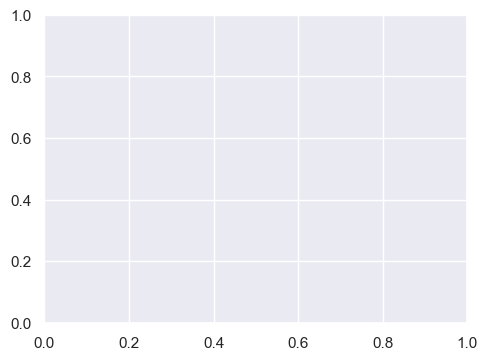

In [33]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()

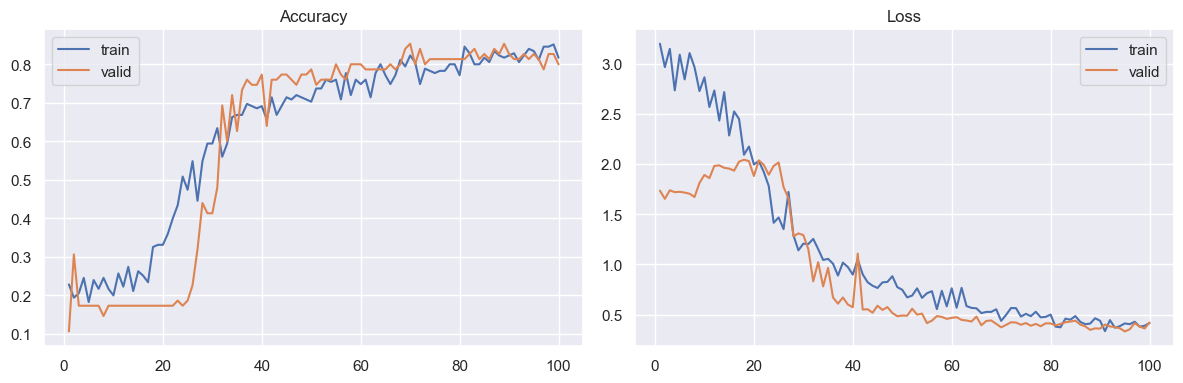

In [41]:
import seaborn as sns
from matplotlib import pyplot

# ... Rest of your code ...

# Extract history values
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=epochs, y=accuracy, label='train')
sns.lineplot(x=epochs, y=val_accuracy, label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=epochs, y=loss, label='train')
sns.lineplot(x=epochs, y=val_loss, label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()


ValueError: Could not interpret value `epoch` for parameter `x`

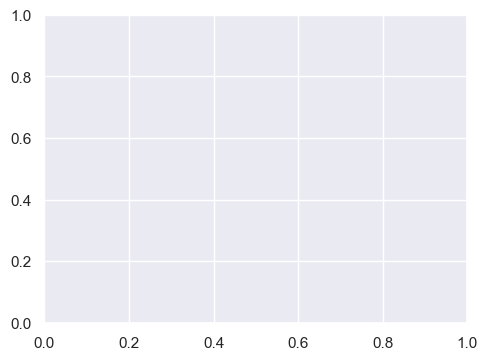

In [48]:
import seaborn as sns
from matplotlib import pyplot

# Assuming 'history' is your training history dictionary

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(data=history, x='epoch', y='accuracy', label='train')
sns.lineplot(data=history, x='epoch', y='val_accuracy', label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(data=history, x='epoch', y='loss', label='train')
sns.lineplot(data=history, x='epoch', y='val_loss', label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()


In [40]:
import seaborn as sns
from matplotlib import pyplot

# Assuming 'history' is your training history dictionary

sns.set()
fig = pyplot.figure(0, (12, 4))

# Add an 'epoch' column based on the index of the dataframe
history['epoch'] = history.index

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(data=history, x='epoch', y='accuracy', label='train')
sns.lineplot(data=history, x='epoch', y='val_accuracy', label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(data=history, x='epoch', y='loss', label='train')
sns.lineplot(data=history, x='epoch', y='val_loss', label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()


AttributeError: 'History' object has no attribute 'index'

<Figure size 1200x400 with 0 Axes>

In [54]:
from matplotlib import pyplot
import seaborn as sns

# Assuming 'history' is your training history dictionary

sns.set()
fig = pyplot.figure(0, (18, 12))

# Add an 'epoch' column based on the epoch number
history['epoch'] = range(1, len(history) + 1)

# Plot Recall
ax = pyplot.subplot(2, 2, 1)
sns.lineplot(data=history, x='epoch', y='macro_recall', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_recall', label='weighted')
pyplot.title('Recall')
pyplot.tight_layout()

# Plot F1-Score
ax = pyplot.subplot(2, 2, 2)
sns.lineplot(data=history, x='epoch', y='macro_f1', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_f1', label='weighted')
pyplot.title('F1-Score')
pyplot.tight_layout()

# Plot Precision
ax = pyplot.subplot(2, 2, 3)
sns.lineplot(data=history, x='epoch', y='macro_precision', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_precision', label='weighted')
pyplot.title('Precision')
pyplot.tight_layout()

# Plot Accuracy
ax = pyplot.subplot(2, 2, 4)
sns.lineplot(data=history, x='epoch', y='macro_accuracy', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_accuracy', label='weighted')
pyplot.title('Accuracy')
pyplot.tight_layout()

pyplot.savefig('metrics_history.png')
pyplot.show()


TypeError: object of type 'History' has no len()

<Figure size 1800x1200 with 0 Axes>

Epoch 1/10
6/6 [==============================] - 12s 2s/step - loss: 0.3309 - accuracy: 0.8514 - val_loss: 0.3955 - val_accuracy: 0.8267
Epoch 2/10
6/6 [==============================] - 11s 2s/step - loss: 0.2837 - accuracy: 0.8686 - val_loss: 0.3557 - val_accuracy: 0.8133
Epoch 3/10
6/6 [==============================] - 13s 2s/step - loss: 0.3510 - accuracy: 0.8686 - val_loss: 0.4107 - val_accuracy: 0.8267
Epoch 4/10
6/6 [==============================] - 12s 2s/step - loss: 0.2982 - accuracy: 0.8629 - val_loss: 0.4204 - val_accuracy: 0.8400
Epoch 5/10
6/6 [==============================] - 13s 2s/step - loss: 0.2767 - accuracy: 0.8743 - val_loss: 0.4266 - val_accuracy: 0.8533
Epoch 6/10
6/6 [==============================] - 12s 2s/step - loss: 0.3285 - accuracy: 0.8857 - val_loss: 0.4242 - val_accuracy: 0.8533
Epoch 7/10
6/6 [==============================] - 12s 2s/step - loss: 0.3616 - accuracy: 0.8400 - val_loss: 0.4370 - val_accuracy: 0.8400
Epoch 8/10
6/6 [==================

KeyError: 'recall'

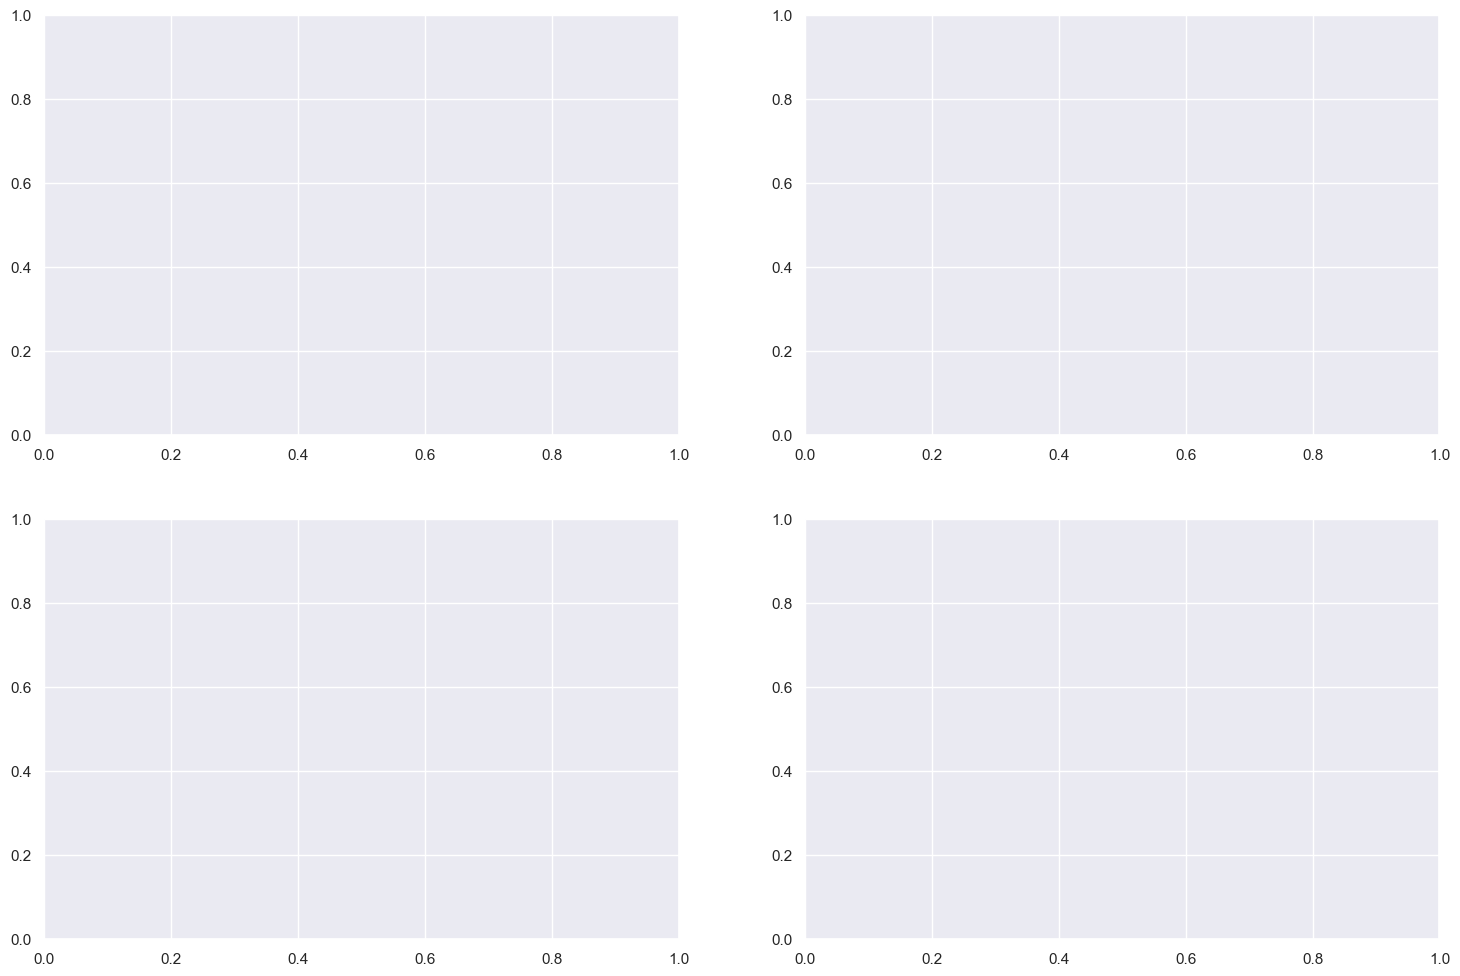

In [59]:
from matplotlib import pyplot as plt
import seaborn as sns

# Example training loop
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

# Extract metrics from the history dictionary
metrics = history.history




`The fluctuations in the epoch metrics is due to the fact that we have very low data for such a complex task.`

3/3 [==============================] - 1s 278ms/step


ValueError: Classification metrics can't handle a mix of multiclass and multilabel-indicator targets

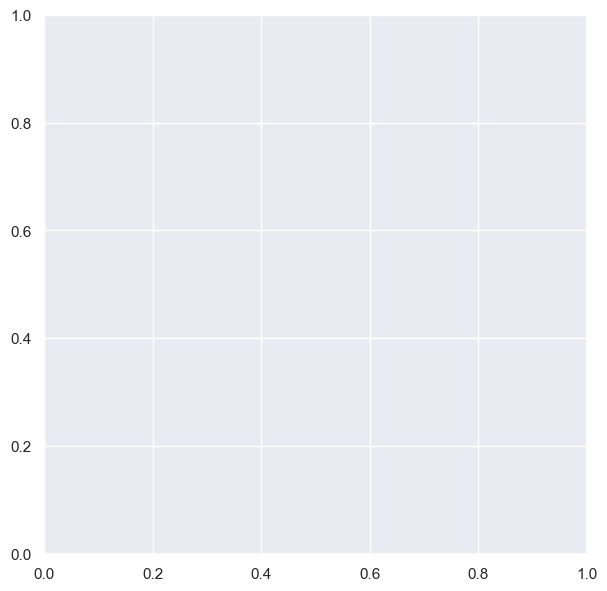

In [49]:
#yhat_valid = model.predict_classes(X_valid)
predictions = (model.predict(X_valid) > 0.5).astype("int32")
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), predictions, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != predictions)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), predictions))

3/3 [==============================] - 1s 268ms/step
Validation accuracy: 0.8


              precision    recall  f1-score   support

           0       0.86      0.96      0.91        25
           1       0.84      1.00      0.91        21
           2       0.69      0.85      0.76        13
           3       0.33      0.12      0.18         8
           4       1.00      0.38      0.55         8

    accuracy                           0.80        75
   macro avg       0.74      0.66      0.66        75
weighted avg       0.78      0.80      0.77        75



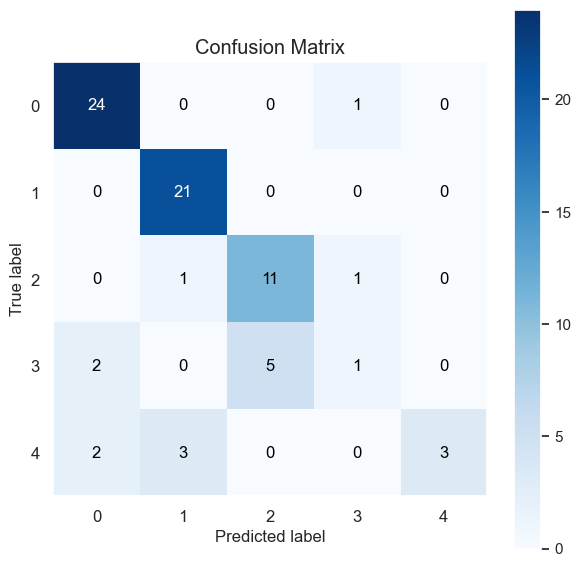

In [42]:
# Get predicted class probabilities
yhat_valid_probs = model.predict(X_valid)

# Convert probabilities to class indices
yhat_valid_classes = np.argmax(yhat_valid_probs, axis=1)

# Plot confusion matrix
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid_classes, figsize=(7,7))
pyplot.savefig("confusion_matrix.png")

# Calculate accuracy and print classification report
accuracy = np.sum(np.argmax(y_valid, axis=1) == yhat_valid_classes) / len(y_valid)
print(f'Validation accuracy: {accuracy}\n\n')

print(classification_report(np.argmax(y_valid, axis=1), yhat_valid_classes))


In [46]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid_classes)

# Calculate true positives, false positives, and false negatives
tp = np.diag(conf_matrix)
fp = np.sum(conf_matrix, axis=0) - tp
fn = np.sum(conf_matrix, axis=1) - tp

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: [0.85714286 0.84       0.6875     0.33333333 1.        ]
Recall: [0.96       1.         0.84615385 0.125      0.375     ]
F1 Score: [0.90566038 0.91304348 0.75862069 0.18181818 0.54545455]


IndexError: index 5 is out of bounds for axis 0 with size 5

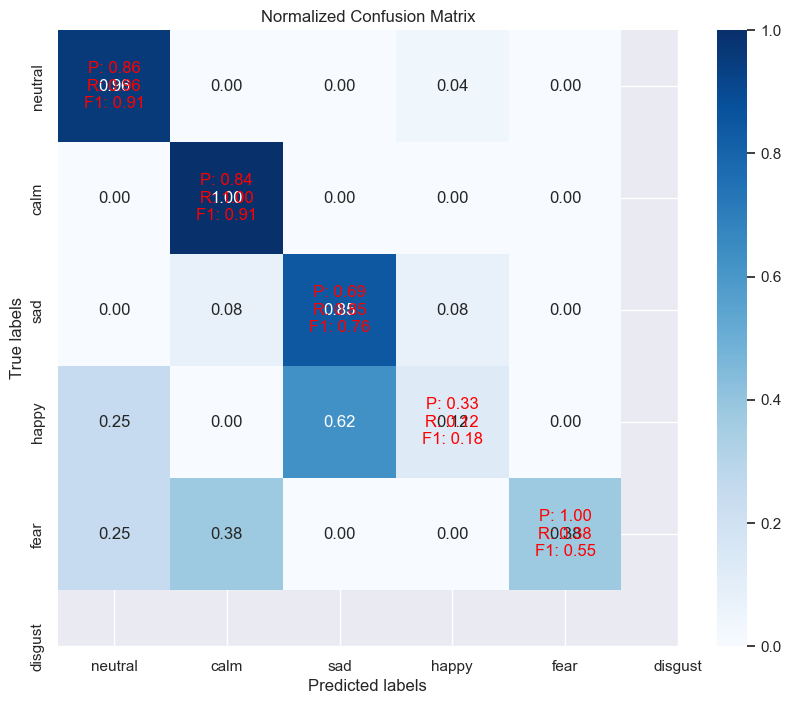

In [47]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid_classes)

# Calculate true positives, false positives, and false negatives
tp = np.diag(conf_matrix)
fp = np.sum(conf_matrix, axis=0) - tp
fn = np.sum(conf_matrix, axis=1) - tp

# Calculate precision, recall, and F1 score
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

# Get class labels
class_labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']

# Calculate the normalized confusion matrix
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')

# Annotate with precision, recall, and F1 score values
for i in range(len(class_labels)):
    plt.text(i + 0.5, i + 0.5, f'P: {precision[i]:.2f}\nR: {recall[i]:.2f}\nF1: {f1_score[i]:.2f}',
             horizontalalignment='center', verticalalignment='center', color='red')

plt.show()


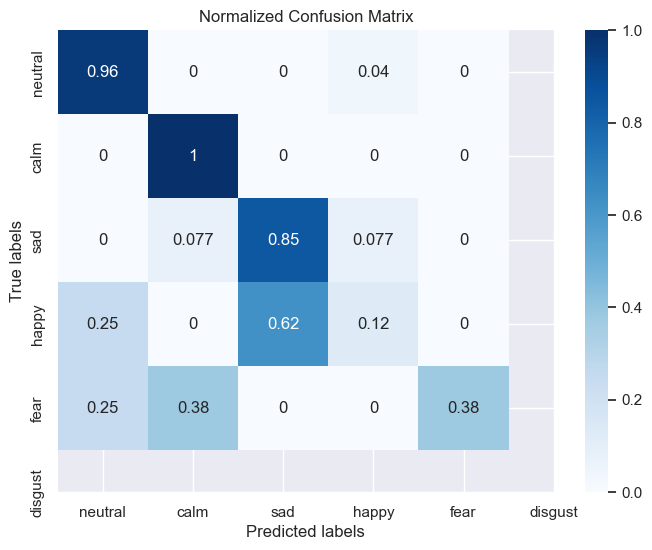

Validation accuracy: 0.8




ValueError: Number of classes, 5, does not match size of target_names, 6. Try specifying the labels parameter

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid_classes)

# Calculate the normalized confusion matrix
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Get class labels
class_labels = ['neutral', 'calm', 'sad', 'happy', 'fear', 'disgust']

# Plot the normalized confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

# Calculate accuracy and print classification report
accuracy = np.sum(np.argmax(y_valid, axis=1) == yhat_valid_classes) / len(y_valid)
print(f'Validation accuracy: {accuracy}\n\n')

print(classification_report(np.argmax(y_valid, axis=1), yhat_valid_classes, target_names=class_labels))


`If we have more data to train then we will get better and more generalized model.`

In [38]:
np.random.seed(0)
indices = np.random.choice(range(X_valid.shape[0]), size=15, replace=False)

fig = pyplot.figure(1, (9,30))

i = 0
for idx in indices:
    true_emotion = label_emotion_mapper[np.argmax(y_valid[idx])]
    pred_emotion = label_emotion_mapper[model.predict_classes(np.expand_dims(X_valid[idx], axis=0))[0]]
    
    for j in range(3):
        i += 1
        ax = pyplot.subplot(15,3,i)
        sample_img = X_valid[idx,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:{true_emotion}, p:{pred_emotion}")

AttributeError: 'Sequential' object has no attribute 'predict_classes'

<Figure size 900x3000 with 0 Axes>

In [50]:
from matplotlib import pyplot
import seaborn as sns

# Assuming 'history' is your training history dictionary

sns.set()
fig = pyplot.figure(0, (18, 12))

# Add an 'epoch' column based on the index of the dataframe
history['epoch'] = history.index

# Plot Recall
ax = pyplot.subplot(2, 2, 1)
sns.lineplot(data=history, x='epoch', y='macro_recall', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_recall', label='weighted')
pyplot.title('Recall')
pyplot.tight_layout()

# Plot F1-Score
ax = pyplot.subplot(2, 2, 2)
sns.lineplot(data=history, x='epoch', y='macro_f1', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_f1', label='weighted')
pyplot.title('F1-Score')
pyplot.tight_layout()

# Plot Precision
ax = pyplot.subplot(2, 2, 3)
sns.lineplot(data=history, x='epoch', y='macro_precision', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_precision', label='weighted')
pyplot.title('Precision')
pyplot.tight_layout()

# Plot Accuracy
ax = pyplot.subplot(2, 2, 4)
sns.lineplot(data=history, x='epoch', y='macro_accuracy', label='macro')
sns.lineplot(data=history, x='epoch', y='weighted_accuracy', label='weighted')
pyplot.title('Accuracy')
pyplot.tight_layout()

pyplot.savefig('metrics_history.png')
pyplot.show()


AttributeError: 'History' object has no attribute 'index'

<Figure size 1800x1200 with 0 Axes>